Reference tutorial: [Link](https://www.tensorflow.org/tutorials/structured_data/time_series)

### Useful imports and setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Load data

In [6]:
DATA_PATH = '../data/extract.txt'

cols_map = {
    "DTS": "crossTime",
    "LANE": "lane",
    "DIR": "direction",
    "SPD": "speed",
    "AX": "nAxles",
    "GW_TOT": "weight",
    "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime, format="%Y%m%dT%H%M%S")
# Convert type column to <category> object
data['type'] = data.type.astype('category')

data.head()

,crossTime,lane,direction,speed,nAxles,weight,type
0,2000-01-04 00:05:57,1,1,101,2,17930,11
1,2000-01-04 00:28:24,1,1,83,2,5230,11
2,2000-01-04 00:34:57,1,1,84,2,8310,11
3,2000-01-04 01:14:14,1,1,89,2,7550,11
4,2000-01-04 02:25:26,1,1,104,3,20930,12


### Data description

In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lane,9999.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
direction,9999.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
speed,9999.0,88.238024,7.028601,21.0,85.0,88.0,89.0,184.0
nAxles,9999.0,3.225723,1.111846,2.0,2.0,3.0,4.0,8.0
weight,9999.0,12335.469547,6135.098224,3500.0,7630.0,11440.0,15630.0,52440.0


### Feature engineering
- Datetime column `crossTime` not useful in its string form. We extract time of day, time of the week, and/or time of the year information to analyse periodicity.

In [10]:
# Transform to seconds
timestamp_s = data.crossTime.map(pd.Timestamp.timestamp)

# Corresponding length in seconds for day, week, year
day_s = 24 * 60 * 60 # 24h x 60m x 60s
week_s = 7 * day_s
year_s = (365.2425)*day_s

In [11]:
def add_time_period_cols(time_length, time_string):
    data[time_string + '_sin'] = np.sin(timestamp_s * (2 * np.pi / time_length))
    data[time_string + '_cos'] = np.cos(timestamp_s * (2 * np.pi / time_length))
    
add_time_period_cols(day_s, 'day')
add_time_period_cols(week_s, 'week')
add_time_period_cols(year_s, 'year')

Text(0.5, 1.0, 'Sin transformed time signal')

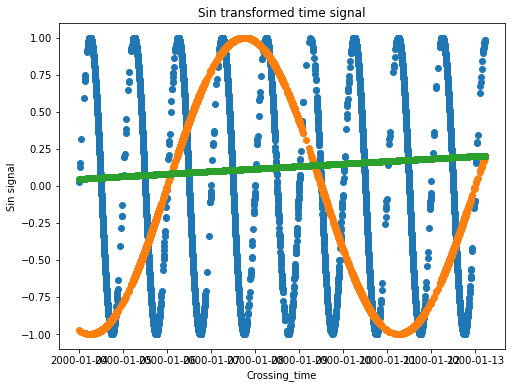

In [27]:
plt.scatter(y=np.array(data['day_sin']), x=data['crossTime'])
plt.scatter(y=np.array(data['week_sin']), x=data['crossTime'])
plt.scatter(y=np.array(data['year_sin']), x=data['crossTime'])
plt.ylabel('Sin signal')
plt.xlabel('Crossing_time')
plt.title('Sin transformed time signal')

As shown above, we obtain a nice periodic signal with respect to the time of day, time of week, and time of year.

### Split data

In [51]:
y, X = data['crossTime'], data.drop(['crossTime', 'type'], axis=1).copy()

n = len(X.index)
train_data = X[0:int(n*0.7)]
val_data = X[int(n*0.7):int(n*0.9)]
test_data = X[int(n*0.9):]

n_features = X.shape[1]

### Normalize data

In [53]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

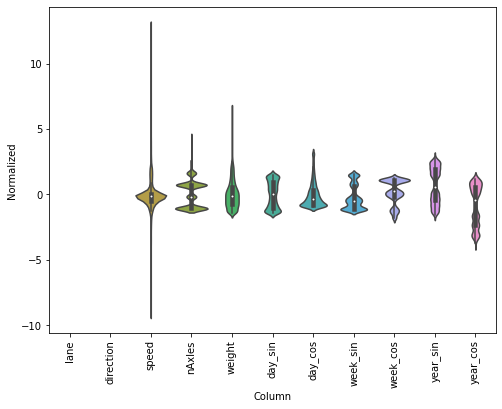

In [54]:
X_std = (X - train_mean) / train_std
X_std = X_std.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=X_std)
_ = ax.set_xticklabels(X.keys(), rotation=90)